In [2]:
import sys 
sys.path.append('..')

import torch
import numpy as np
from scipy import signal

%load_ext autoreload
%autoreload 2
from networks import *
from utils import *
from losses import *

import matplotlib.pyplot as plt
from math import ceil


In [3]:
def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]


def get_middle_arr2d(img, shape):
    x_len, y_len = shape[0], shape[1]
    x_start = int(img.shape[0]/2) - int(x_len/2)
    y_start = int(img.shape[1]/2) - int(y_len/2)
    return img[x_start:x_start+x_len, y_start:y_start+y_len]

    
def circle_img(shape, lag=(0, 0), fill_val=0, circle_val=1., radius=1.):
    im = torch.zeros(shape) + fill_val
    
    xarr = torch.linspace(-shape[0], shape[0], shape[0])
    yarr = torch.linspace(-shape[1], shape[1], shape[1])
    xx, yy = torch.meshgrid(xarr, yarr)
    
    lagy, lagx = lag
    dist = torch.sqrt((xx-lagx)**2 + (yy-lagy)**2)
    idx = torch.where(dist <= radius*2)
    im[idx[0], idx[1]] = circle_val   
    
    return im

def square_img(shape, lag=(0, 0), fill_val=0, square_val=1., radius=1.):
    im = torch.zeros(shape) + fill_val
    
    xarr = torch.linspace(-shape[0], shape[0], shape[0])
    yarr = torch.linspace(-shape[1], shape[1], shape[1])
    
    lagx, lagy = lag
    
    idx = torch.where(xarr > 0 + lagx)[0][0]
    idy = torch.where(yarr > 0 + lagy)[0][0]
    im[idx-radius:idx+radius, idy-radius:idy+radius] = square_val   
    
    return im



In [4]:

def test_loss(input, target, awi_loss, figtitle=None):
    assert input.shape == target.shape
    h, w = input.shape[2:]
    
    awi_loss.return_filters = True
    f = awi_loss(input, target)
    v, T = awi_loss.v_all, awi_loss.T_arr
    nd = len(v.shape) - 1
   
    if nd == 1:
        D = signal.convolve(target.flatten(start_dim=0), v[0], mode="full")
        D = get_middle_arr(D, h*w).reshape(h, w)
    elif nd == 2:
        D = signal.convolve2d(target.squeeze(0).squeeze(0), v[0])
        D = get_middle_arr2d(D, (h, w))#.reshape(h, w)
    else:
        raise Exception(" Only supporting filters of dimensions 1 and 2, but found %g dimensions"%nd)
    
    fig, ax = plt.subplots(1, 6, figsize=(30, 4))
    if figtitle is not None:
        fig.suptitle(figtitle, fontsize=16)
        
    im = ax[0].imshow(input.squeeze(0).squeeze(0), vmin=0, vmax=1)
    fig.colorbar(im, ax=ax[0])
    ax[0].set_title("Input")

    im = ax[1].imshow(target.squeeze(0).squeeze(0), vmin=0, vmax=1)
    fig.colorbar(im, ax=ax[1])
    ax[1].set_title("target")

    im = ax[2].imshow(D, vmin=0, vmax=1)
    fig.colorbar(im, ax=ax[2])
    ax[2].set_title("target*filter")
    
    im = ax[3].imshow(D - input.numpy().squeeze(0).squeeze(0), vmin=-input.max()/10, vmax=input.max()/10)
    fig.colorbar(im, ax=ax[3])
    ax[3].set_title("target*filter - input")

    if nd == 1:
        xarr = torch.linspace(-len(v[0].flatten()), len(v[0].flatten()),  len(v[0].flatten())).float()
        
        ax[4].plot(xarr, v[0].flatten())
        peak = int(xarr[torch.argmax(v[0].flatten()).item()])
        ax[4].set_title("Filter / len=%.3f/ lag peak=%g / loss=%.3f"%(v[0].sum(), peak, f))
        ax[4].set_xlabel("Lag")
        
        ax[5].plot(xarr, T.detach())
        peak = int(xarr[torch.argmin(T).item()])
        ax[5].set_title("penalty function, min lag %g "%peak)
        ax[5].set_xlabel("Lag")
        
    elif nd == 2:
        xarr = np.linspace(-v[0].shape[0], v[0].shape[0], v[0].shape[0])
        yarr = np.linspace(-v[0].shape[1], v[0].shape[1], v[0].shape[1])
        xx, yy = np.meshgrid(xarr, yarr)

                    
        im  = ax[4].contourf(xx, yy, v[0], levels=500)
        fig.colorbar(im, ax=ax[4])
        peaky, peakx = torch.where(v[0] == v[0].max())
        peaky, peakx  = int(yarr[peaky.item()]), int(xarr[peakx.item()])
        ax[4].set_title("Filter 2D / len={:.3f}/ lag peak=({:d}, {:d})/ loss={:.3f}".format(v[0].sum(), peaky, peakx, f))
        ax[4].set_xlabel("Lag X")
        ax[4].set_ylabel("Lag Y")
        

        im = ax[5].contourf( xx, yy, T.detach(), levels=500)
        peaky, peakx = torch.where(T == T.max())
        peaky, peakx  = int(yarr[peaky]), int(xarr[peakx])
        fig.colorbar(im, ax=ax[5])
        ax[5].set_title("penalty function, min lag  ({:d}, {:d}) ".format(peaky, peakx))
        ax[5].set_xlabel("Lag X")
        ax[5].set_ylabel("Lag Y")
        
    plt.show()

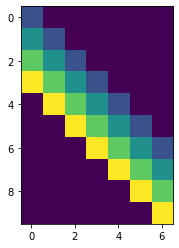

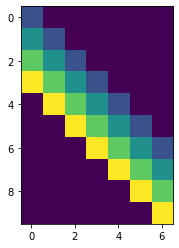

True


In [7]:
def make_toeplitz(a):
    h = a.size(0)
    A = torch.zeros((3*h-2, 2*h-1), device=a.device)
    for i in range(2*h-1):
        A[i:i+h, i] = a[:]  
    A = A.to(a.device)
    return A

def make_toeplitz_roll(a):
    h = a.size(0)
    r, c = 3*h-2, 2*h-1 # Size of toeplitz matrix for filter of size 2h-1
    # r, c = 2*h-1, h # Size of toeplitz matrix for filter of size h
    z = torch.zeros(r - h, device=a.device)
    x = torch.cat([a, z], dim = 0)
    A_t = torch.zeros((c, r), device=a.device)
    for j in range(c):
        A_t[j] = torch.roll(x, j)
    return A_t.T

def make_toeplitz(a):
    h = a.size(0)
    r, c = 3*h-2, 2*h-1 # Size of toeplitz matrix for filter of size 2h-1
    # r, c = 2*h-1, h # Size of toeplitz matrix for filter of size h
    z = torch.zeros(r - h, device=a.device)
    x = torch.cat([a, z], dim = 0)
    A = torch.zeros((r, c), device=a.device)
    for j in range(c):
        A[:, j] = torch.roll(x, j)
    return A

a = torch.tensor([1,2,3,4])
A = make_toeplitz(a)
plt.imshow(A)
plt.show()

Aroll = make_toeplitz_roll(a)
plt.imshow(Aroll)
plt.show()

print(torch.all(Aroll == A).item())

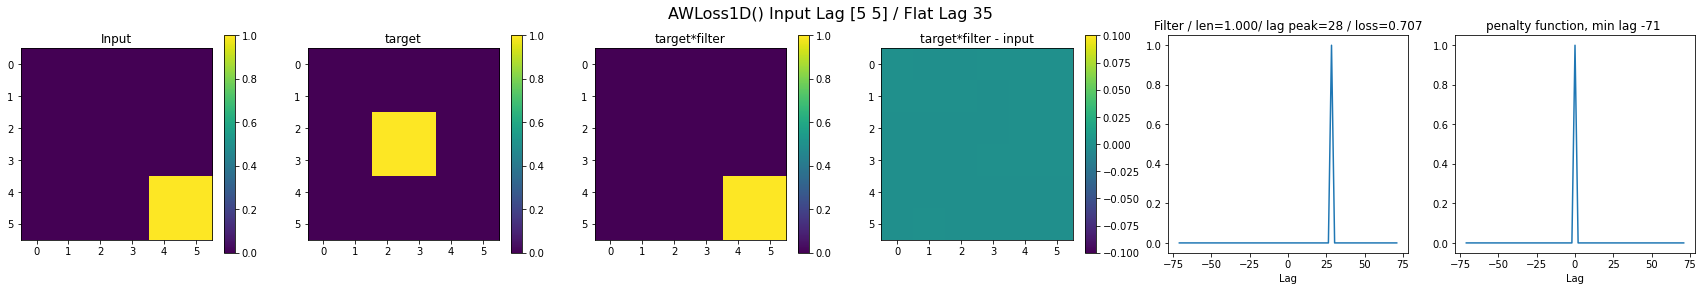

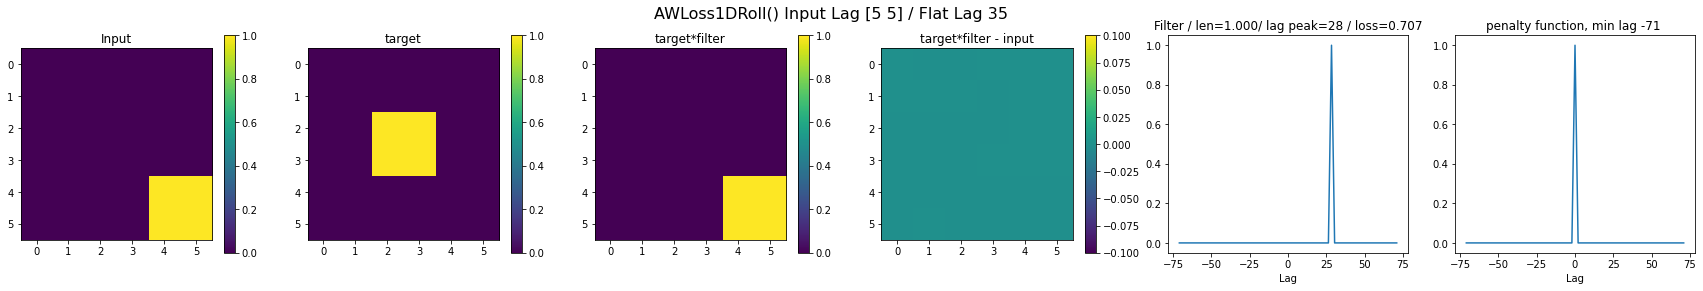

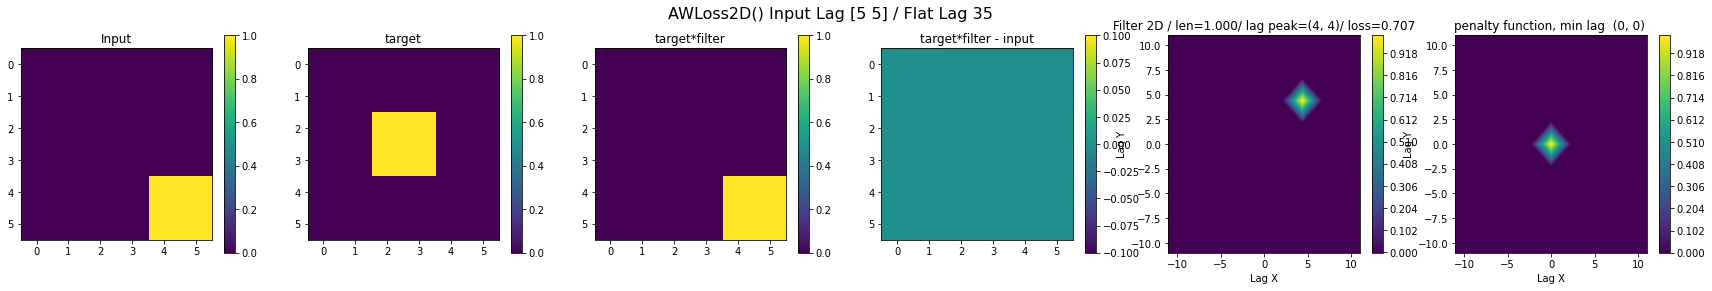

In [11]:
n = 6
losses = [
    AWLoss1D(store_filters=True),
    AWLoss1DRoll(store_filters=True),
    AWLoss2D(store_filters=True),
    ]

P = torch.zeros((n, n))
for i in range(P.size(0)):
    P[i, :] = torch.zeros(n) + i + 1
P = P.unsqueeze(0).unsqueeze(0)

for awi_loss in losses:
    r = 1
    lag = np.array([5, 5])
    flatlag = n*lag[0] + lag[1]
    input = square_img((n, n), lag=lag, radius=r).unsqueeze(0).unsqueeze(0)  
    target = square_img((n, n), lag=(0, 0), radius=r).unsqueeze(0).unsqueeze(0) 
    test_loss(input, target, awi_loss, figtitle="{} Input Lag {} / Flat Lag {}".format(awi_loss, lag, flatlag))


AWLoss1D()


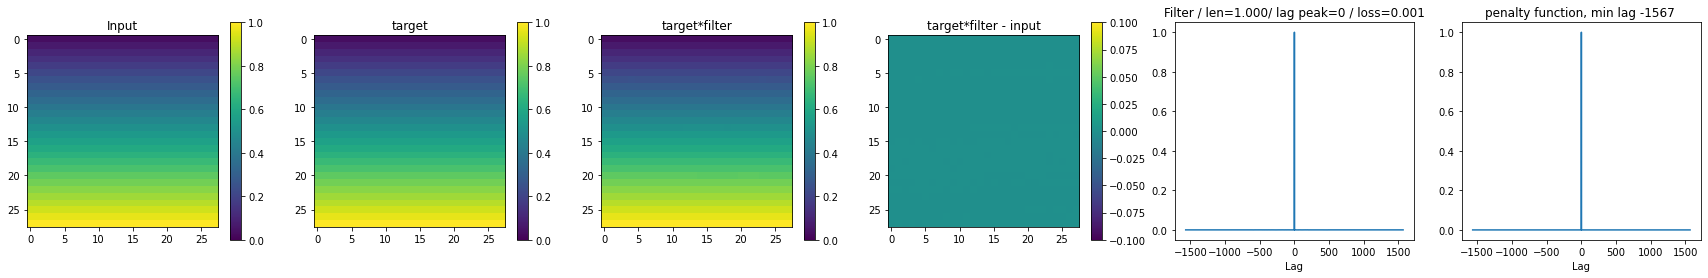

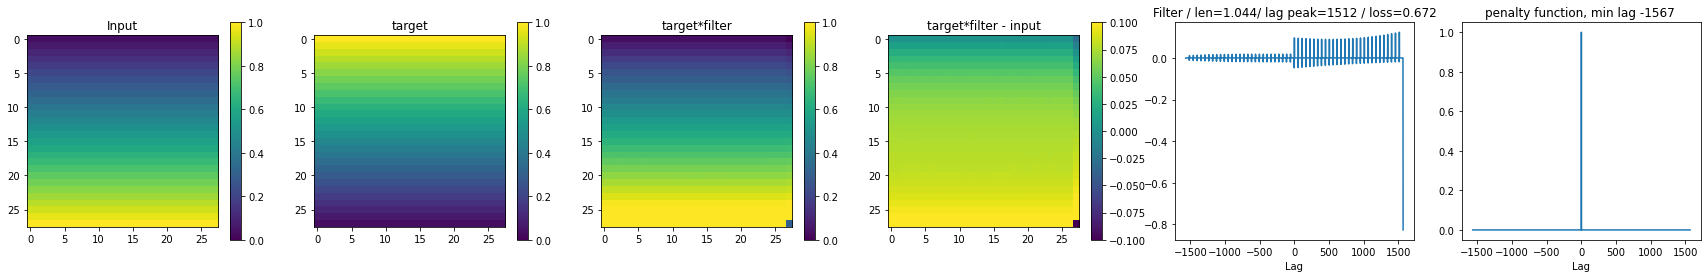

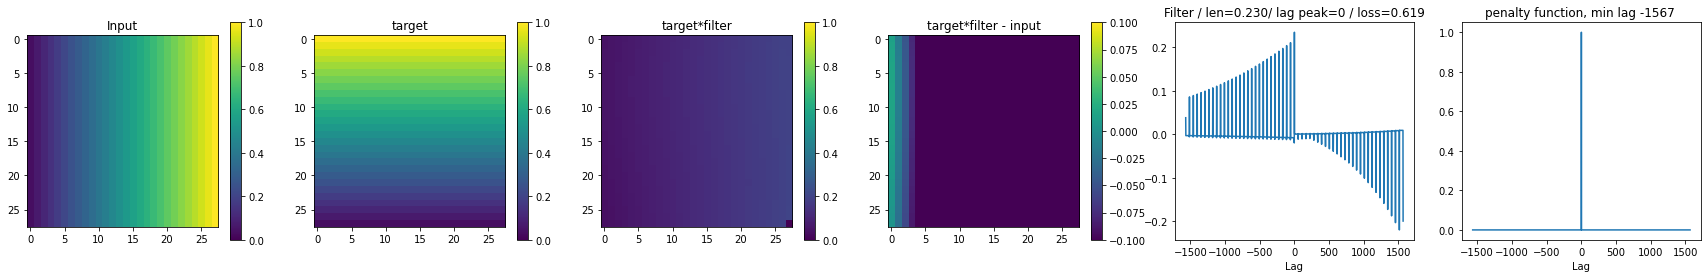

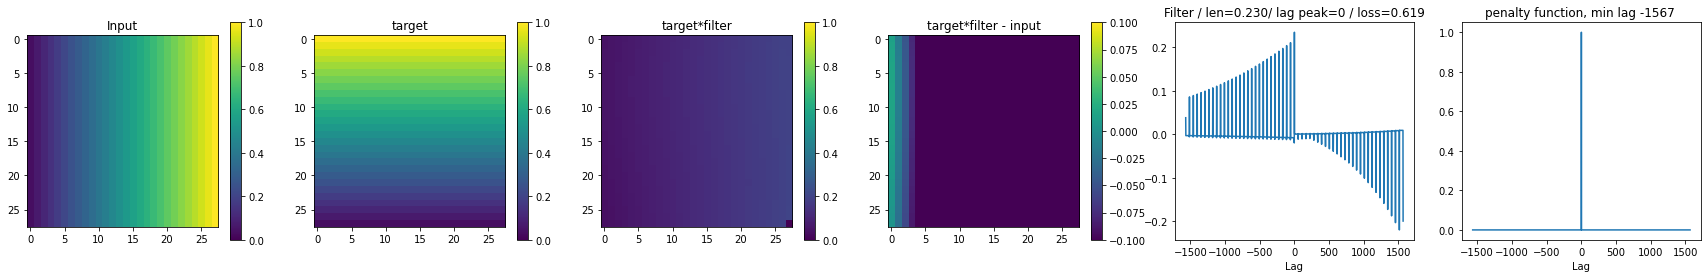

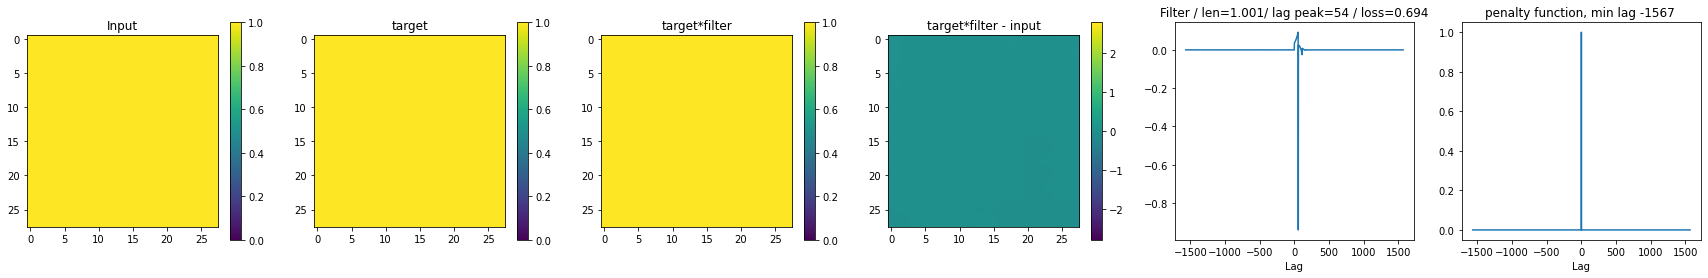

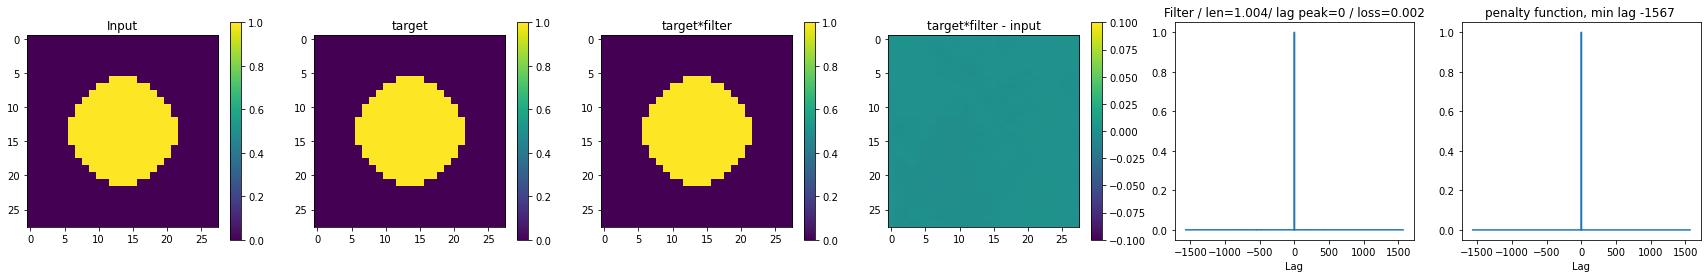

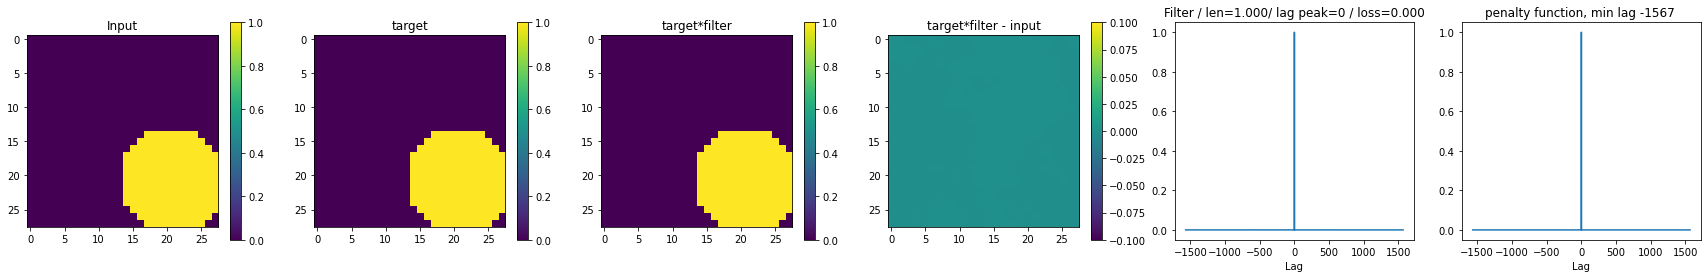

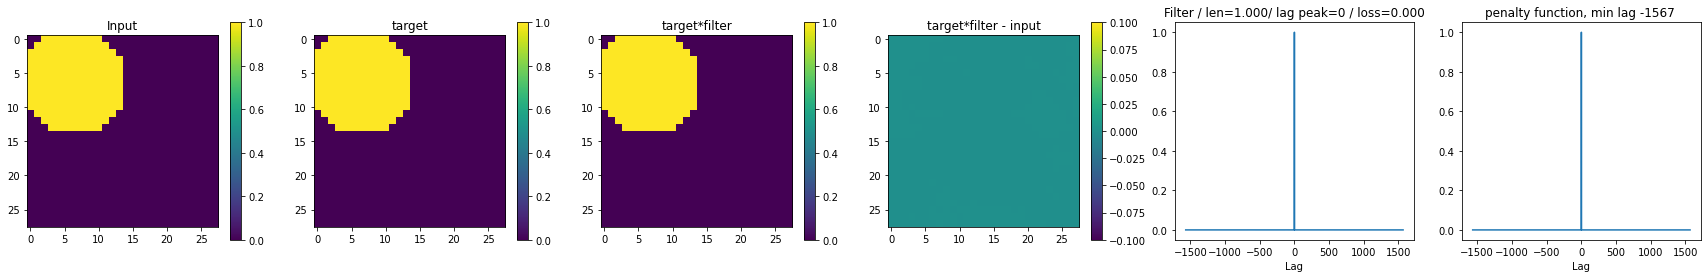

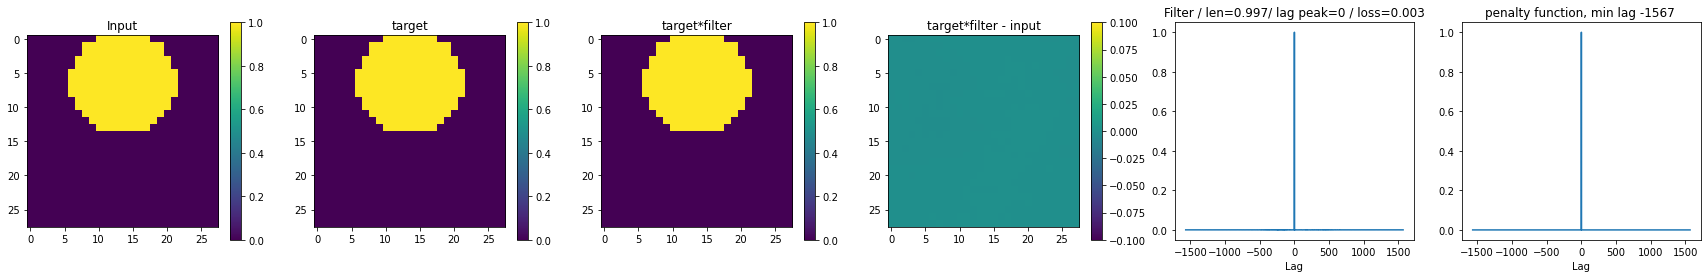

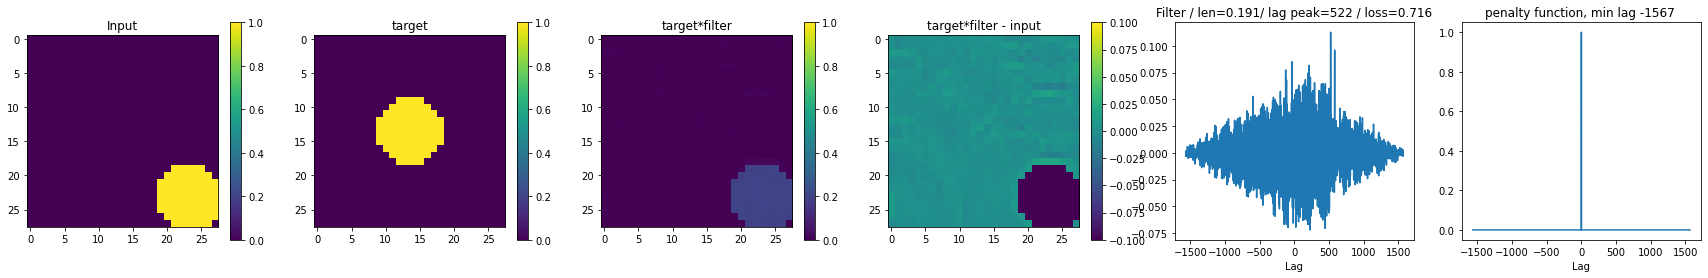

Input lag:  (0, 0)


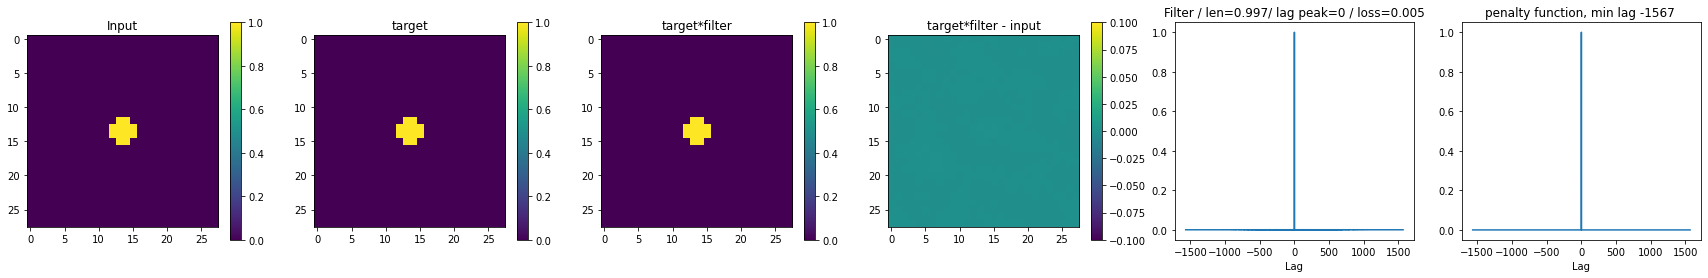

AWLoss1DRoll()


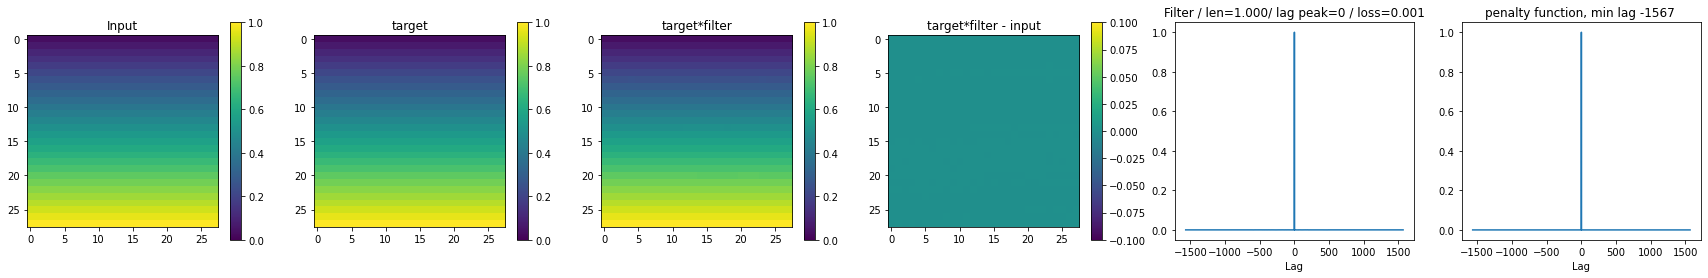

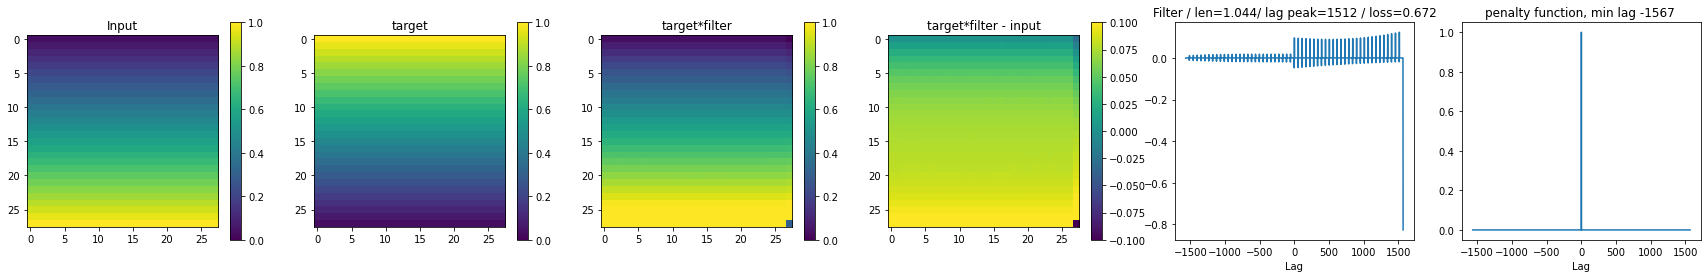

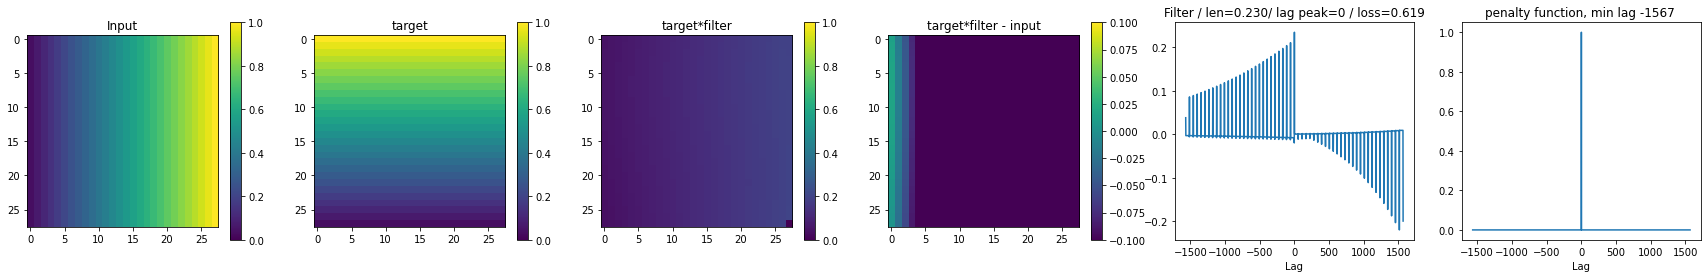

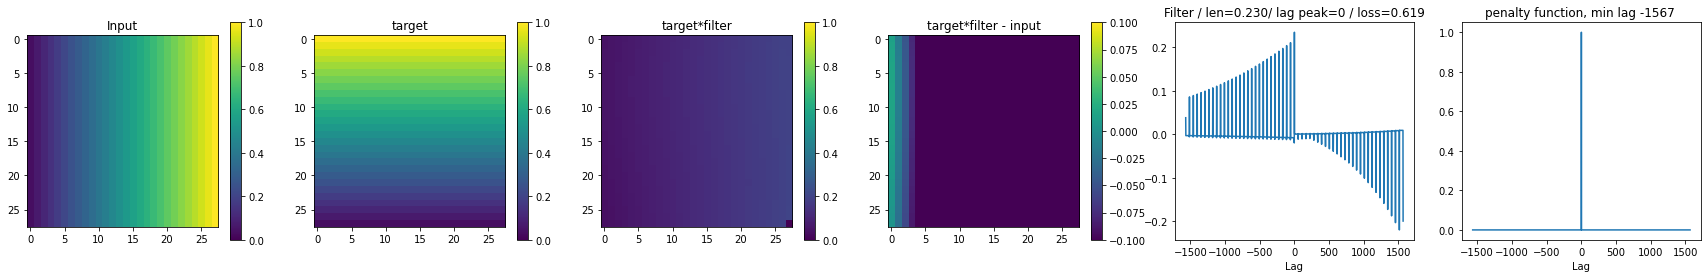

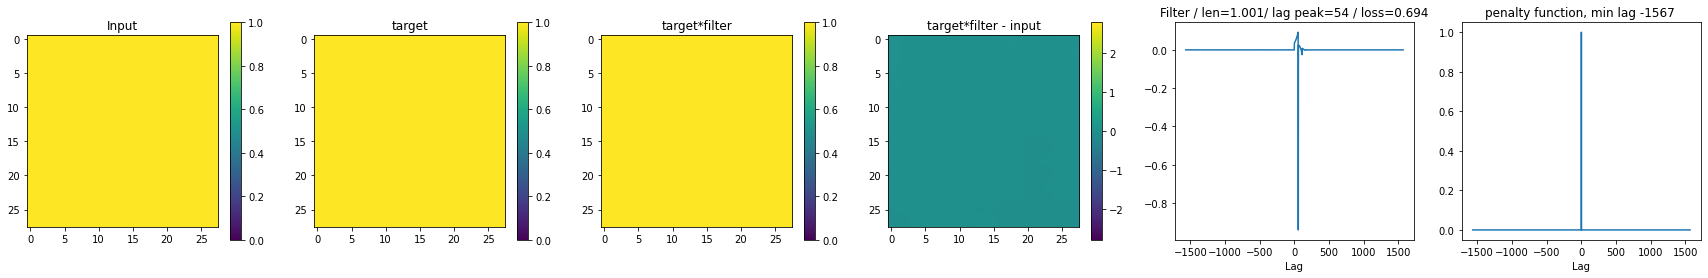

KeyboardInterrupt: 

In [9]:
n = 28
losses = [AWLoss1D(store_filters=True),
          AWLoss1DRoll(store_filters=True),
          AWLoss2D(store_filters=True)]

for awi_loss in losses:
    print(awi_loss)

    
    P = torch.zeros(1,1,n,n)
    for i in range(n):
        P[0, 0, i, :] = (torch.ones(1, n) + i)/n
        
    # input,  target = P[:], P[:]
    # test_loss(input, target, awi_loss)

    # input, target = P[:], torch.flipud(P[0, 0]).unsqueeze(0).unsqueeze(0)
    # test_loss(input, target, awi_loss)

    # input, target = torch.transpose(P, dim0=2, dim1=3), torch.flipud(P[0, 0]).unsqueeze(0).unsqueeze(0)
    # test_loss(input, target, awi_loss)

    # input, target = torch.transpose(P, dim0=2, dim1=3), torch.flipud(P[0, 0]).unsqueeze(0).unsqueeze(0)
    # test_loss(input, target, awi_loss)

    # for i in range(n):
    #     P[0, 0, :, i] = torch.ones(1, n) + i
    # input, target = P[:], torch.fliplr(P[0, 0]).unsqueeze(0).unsqueeze(0)
    # test_loss(input, target, awi_loss)

    circle = circle_img((n, n), lag=(0, 0), radius=8).unsqueeze(0).unsqueeze(0)
    target, input = circle, circle
    test_loss(input, target, awi_loss)

    circle = circle_img((n, n), lag=(15, 15), radius=8).unsqueeze(0).unsqueeze(0)
    target, input = circle, circle
    test_loss(input, target, awi_loss)

    circle = circle_img((n, n), lag=(-15, -15), radius=8).unsqueeze(0).unsqueeze(0)
    target, input = circle, circle
    test_loss(input, target, awi_loss)

    circle = circle_img((n, n), lag=(0, -15), radius=8).unsqueeze(0).unsqueeze(0)
    target, input = circle, circle
    test_loss(input, target, awi_loss)

    circle = circle_img((n, n), lag=(20, 20), radius=5).unsqueeze(0).unsqueeze(0)
    input, target = circle, circle_img((n, n), lag=(0, 0), radius=5).unsqueeze(0).unsqueeze(0)
    test_loss(input, target, awi_loss)
    
    lag = (0, 0)
    r = 2
    print("Input lag: ", lag)
    input = circle_img((n, n), lag=lag, radius=r).unsqueeze(0).unsqueeze(0)
    target = circle_img((n, n), lag=(0, 0), radius=r).unsqueeze(0).unsqueeze(0)
    test_loss(input, target, awi_loss)
